Loading preprocessed data...
Loaded data with shape: (10094, 2359)

Depression Score Distribution:
Median score: -0.27
Number of high depression cases: 3533
Number of low depression cases: 6561
Training LASSO model...

Training Random Forest model...

Evaluating models...

Plotting feature importance...


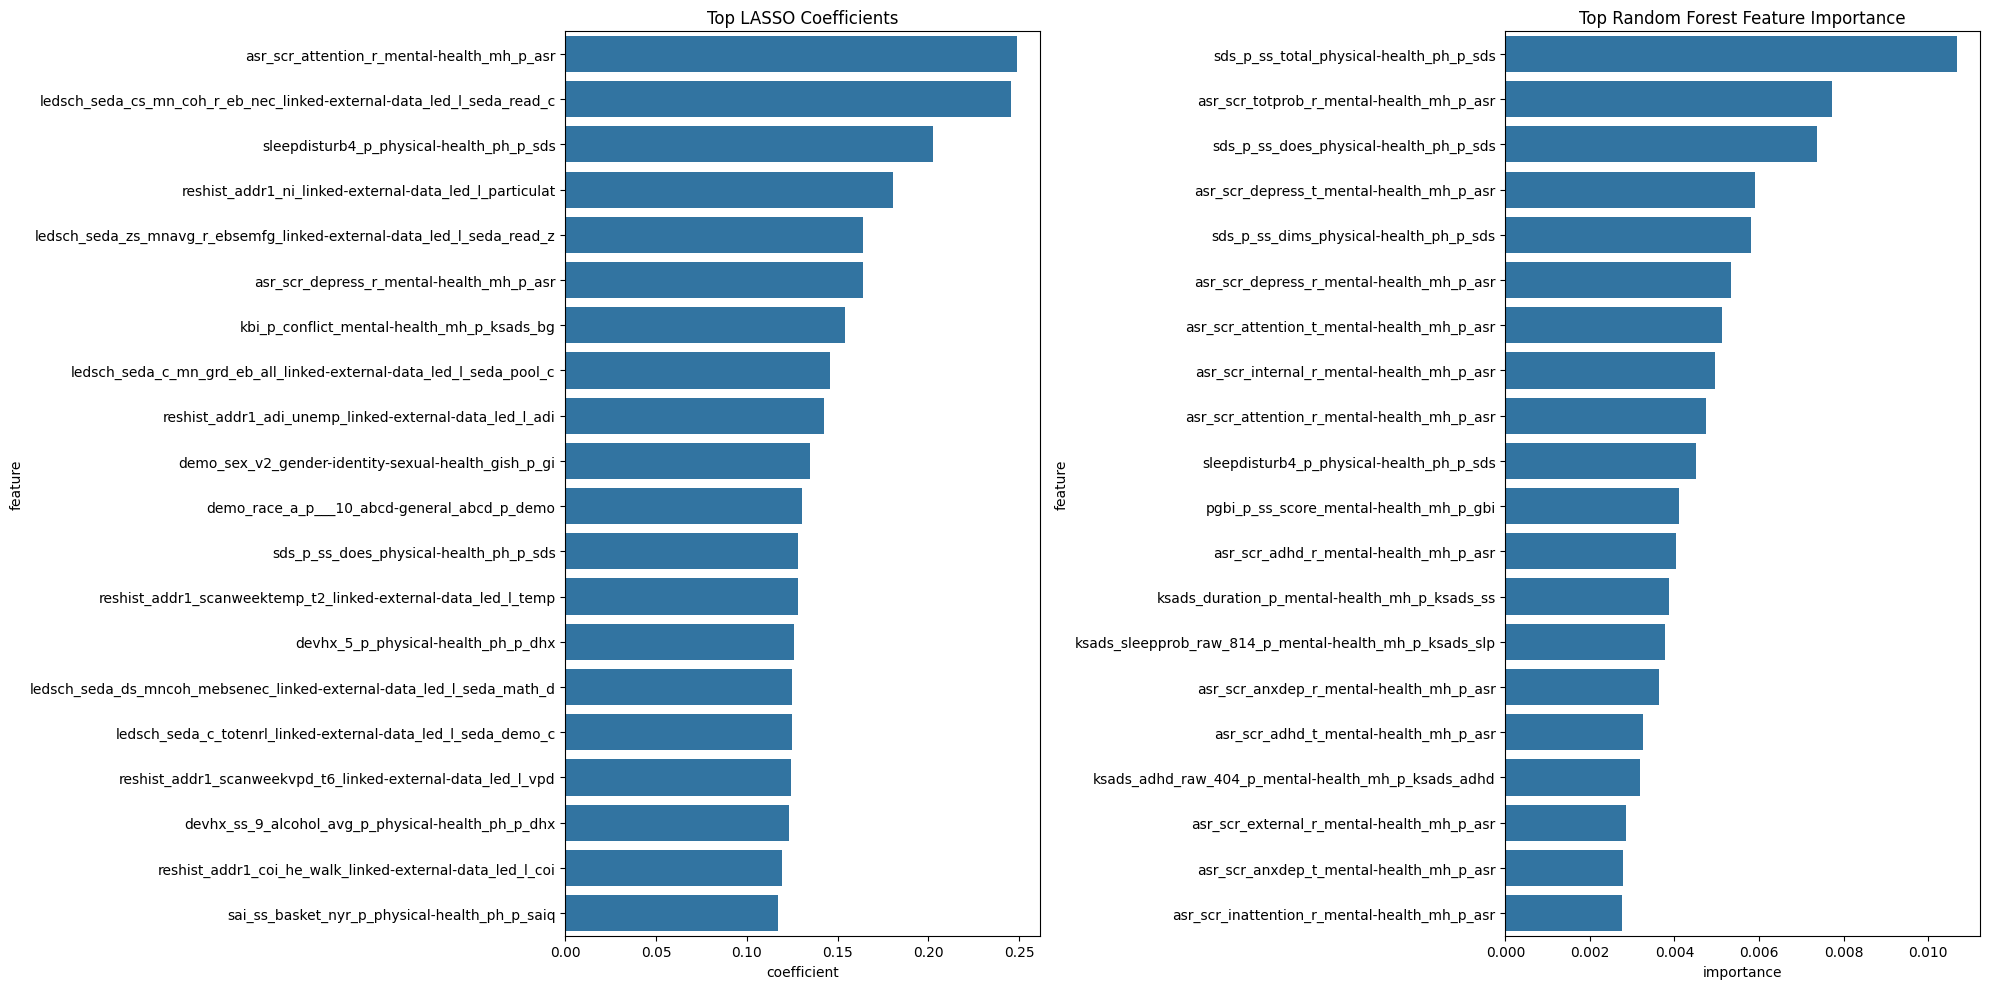


Saving results...

Done!


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

def load_preprocessed_data():
    """Load the preprocessed data and return DF"""
    data_path = Path('../data/processed/preprocessed_data.csv')
    if not data_path.exists():
        raise FileNotFoundError("Preprocessed data not found. Please run 01_data_preprocessing first.")
    
    df = pd.read_csv(data_path)
    print(f"Loaded data with shape: {df.shape}")
    return df

class DepressionPredictor:
    def __init__(self, df, test_size=0.2, random_state=42):
        """
        Initialize the depression prediction
        
        Parameters:
        -----------
        df : pandas.DataFrame
            Preprocessed dataframe containing features and outcome variables 
        test_size : float
            % of dataset to include in the test split
        random_state : int
            Random state for reproducibility
        """
        self.test_size = test_size
        self.random_state = random_state
        self.scaler = StandardScaler()
        
        # Separate features and target
        self.X = df.drop(['src_subject_id', 'depression_score'], axis=1)
        
        # Convert continuous depression scores to binary categories
        # Using median as threshold
        median_score = df['depression_score'].median()
        self.y = (df['depression_score'] > median_score).astype(int)
        
        print(f"\nDepression Score Distribution:")
        print(f"Median score: {median_score:.2f}")
        print(f"Number of high depression cases: {self.y.sum()}")
        print(f"Number of low depression cases: {(self.y == 0).sum()}")
        
        # Split data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=random_state, stratify=self.y
        )
        
        # Scale features
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)
        
        # Initialize models
        self.lasso_model = None
        self.rf_model = None
        
    def train_lasso(self):
        """Train logistic regression with LASSO regularization"""
        # Initialize and fit model
        self.lasso_model = LogisticRegression(
            C=0.1,
            penalty='l1',
            solver='liblinear',
            max_iter=1000,
            random_state=self.random_state
        )
        
        # Fit model
        self.lasso_model.fit(self.X_train_scaled, self.y_train.values.ravel())
        
        # Get feature importance
        feature_importance = pd.DataFrame({
            'feature': self.X_train.columns,
            'coefficient': np.abs(self.lasso_model.coef_[0])
        })
        feature_importance = feature_importance.sort_values('coefficient', ascending=False)
        
        return feature_importance
    
    def train_random_forest(self):
        """Train random forest classifier"""
        # Initialize and fit model
        self.rf_model = RandomForestClassifier(
            n_estimators=200,
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=self.random_state
        )
        
        # Fit model
        self.rf_model.fit(self.X_train_scaled, self.y_train.values.ravel())
        
        # Get feature importance
        feature_importance = pd.DataFrame({
            'feature': self.X_train.columns,
            'importance': self.rf_model.feature_importances_
        })
        feature_importance = feature_importance.sort_values('importance', ascending=False)
        
        return feature_importance
    
    def evaluate_models(self):
        """Evaluate both models on test set"""
        results = {}
        
        # Evaluate LASSO
        if self.lasso_model is not None:
            lasso_pred = self.lasso_model.predict(self.X_test_scaled)
            lasso_prob = self.lasso_model.predict_proba(self.X_test_scaled)[:, 1]
            
            results['lasso'] = {
                'predictions': lasso_pred,
                'probabilities': lasso_prob,
                'classification_report': classification_report(self.y_test, lasso_pred),
                'confusion_matrix': confusion_matrix(self.y_test, lasso_pred),
                'roc_auc': roc_auc_score(self.y_test, lasso_prob)
            }
        
        # Evaluate Random Forest
        if self.rf_model is not None:
            rf_pred = self.rf_model.predict(self.X_test_scaled)
            rf_prob = self.rf_model.predict_proba(self.X_test_scaled)[:, 1]
            
            results['random_forest'] = {
                'predictions': rf_pred,
                'probabilities': rf_prob,
                'classification_report': classification_report(self.y_test, rf_pred),
                'confusion_matrix': confusion_matrix(self.y_test, rf_pred),
                'roc_auc': roc_auc_score(self.y_test, rf_prob)
            }
        
        return results
    
    def plot_feature_importance(self, top_n=20):
        """Plot feature importance for both models"""
        if self.lasso_model is not None and self.rf_model is not None:
            # Get feature importance
            lasso_importance = self.train_lasso()
            rf_importance = self.train_random_forest()
            
            # Create subplots
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
            
            # Plot LASSO coefficients
            sns.barplot(data=lasso_importance.head(top_n), x='coefficient', y='feature', ax=ax1)
            ax1.set_title('Top LASSO Coefficients')
            
            # Plot Random Forest importance
            sns.barplot(data=rf_importance.head(top_n), x='importance', y='feature', ax=ax2)
            ax2.set_title('Top Random Forest Feature Importance')
            
            plt.tight_layout()
            plt.show()
    
    def save_results(self, output_dir):
        """Save model results and feature importance"""
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)
        
        # Save feature importance
        if self.lasso_model is not None:
            lasso_importance = self.train_lasso()
            lasso_importance.to_csv(output_dir / 'lasso_feature_importance.csv', index=False)
        
        if self.rf_model is not None:
            rf_importance = self.train_random_forest()
            rf_importance.to_csv(output_dir / 'random_forest_feature_importance.csv', index=False)
        
        # Save evaluation results
        results = self.evaluate_models()
        for model_name, model_results in results.items():
            with open(output_dir / f'{model_name}_results.txt', 'w') as f:
                f.write(f"Classification Report:\n{model_results['classification_report']}\n")
                f.write(f"ROC AUC Score: {model_results['roc_auc']:.3f}\n")
                f.write("\nConfusion Matrix:\n")
                f.write(str(model_results['confusion_matrix']))

def main():
    # Load preprocessed data
    print("Loading preprocessed data...")
    df = load_preprocessed_data()
    
    # Set output directory
    output_dir = '../results/model_results'
    
    # Initialize predictor
    predictor = DepressionPredictor(df)
    
    # Train models
    print("Training LASSO model...")
    lasso_importance = predictor.train_lasso()
    
    print("\nTraining Random Forest model...")
    rf_importance = predictor.train_random_forest()
    
    # Evaluate models
    print("\nEvaluating models...")
    results = predictor.evaluate_models()
    
    # Plot feature importance
    print("\nPlotting feature importance...")
    predictor.plot_feature_importance()
    
    # Save results
    print("\nSaving results...")
    predictor.save_results(output_dir)
    
    print("\nDone!")

if __name__ == "__main__":
    main()